In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from pprint import pprint
np.random.seed(2018)
import nltk
import re
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import os
import tqdm
import warnings
#nltk.download('wordnet')#if it is already downloaded just import nltk
stemmer = SnowballStemmer('english')
warnings.filterwarnings('ignore')


In [2]:
#Loading the Dataset
df = pd.read_csv(r"C:\Users\Ayush\hydrogen fuel data.csv",low_memory=False)
df["Result"] = df['Message'].astype(str) +"-"+ df["Link Text"].astype(str) + "-" + df['Image Text']

In [3]:
data_text = df[['Result']]
data_text['index'] = data_text.index
documents = data_text

In [4]:
#Preprocessing of the DataFrame
#Reducing text to its initial lemma
#removing stopwords
#removing emojis
#avoiding text which is shorter than 3 words
#Transforming text into Lowercase
unrelatedwords=['hydrogen','https','energy','fuel','fuels','energies','fuelled','fuelling']

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            if token not in unrelatedwords:
                result.append(lemmatize_stemming(token))
    return result


def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(text)


In [9]:
documents['Result'] = documents['Result'].astype(str)
#preprocessing the dataset
processed_docs = documents['Result'].map(preprocess)
print(processed_docs[:10])

0                                                   []
1                                                   []
2                                                   []
3    [acwa, power, develop, investor, oper, power, ...
4                                                   []
5                                                   []
6                                                   []
7                                                   []
8                                                   []
9                                                   []
Name: Result, dtype: object


In [10]:
#Creating a dictionary from ‘processed_docs’ which contains the number of times a word appears in the training set.
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 acwa
1 announc
2 arabia
3 ceremoni
4 compani
5 decarbon
6 desalin
7 develop
8 digit
9 drive
10 establish


In [11]:
#Filtering out the dictionary and only keeping the first 100000 most frequent tokens.
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [12]:
#For each document we create a dictionary
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
print(bow_corpus[4310])

[]


In [13]:
#Previewing the Bag Of Words for our sample preprocessed document.
bow_doc_4310 = bow_corpus[4310]

for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                                     dictionary[bow_doc_4310[i][0]], 
                                                     bow_doc_4310[i][1]))


In [14]:
#creatin a tifdif model on bow_corpus
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
for doc in corpus_tfidf:
    pprint(doc)
    break

[]


In [15]:
#Establishing The Lda Model.
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [16]:
#For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.016*"photo" + 0.013*"bubbl" + 0.012*"gastech" + 0.011*"skin" + 0.010*"alga" + 0.010*"furbi" + 0.009*"power" + 0.009*"come" + 0.009*"book" + 0.008*"petopia"
Topic: 1 
Words: 0.015*"water" + 0.013*"power" + 0.013*"need" + 0.011*"nuclear" + 0.009*"engin" + 0.007*"fusion" + 0.007*"sourc" + 0.007*"upskil" + 0.007*"alarm" + 0.006*"aviat"
Topic: 2 
Words: 0.027*"power" + 0.020*"green" + 0.013*"renew" + 0.012*"africa" + 0.011*"industri" + 0.010*"technolog" + 0.009*"project" + 0.009*"product" + 0.009*"futur" + 0.009*"carbon"
Topic: 3 
Words: 0.036*"electr" + 0.033*"cell" + 0.031*"vehicl" + 0.030*"power" + 0.011*"batteri" + 0.010*"emiss" + 0.010*"develop" + 0.009*"technolog" + 0.009*"photo" + 0.008*"hybrid"
Topic: 4 
Words: 0.014*"water" + 0.013*"product" + 0.013*"skin" + 0.012*"power" + 0.011*"toubro" + 0.011*"larsen" + 0.011*"indianoil" + 0.010*"teri" + 0.010*"process" + 0.009*"norwegian"
Topic: 5 
Words: 0.024*"say" + 0.021*"green" + 0.014*"power" + 0.013*"countri" + 0.012*

In [17]:
#Running LDA using TF-IDF
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.010*"toyota" + 0.009*"vehicl" + 0.009*"power" + 0.009*"labour" + 0.008*"year" + 0.007*"electr" + 0.006*"cell" + 0.006*"car" + 0.006*"nuclear" + 0.005*"green"
Topic: 1 Word: 0.013*"electr" + 0.010*"power" + 0.007*"cell" + 0.007*"pari" + 0.006*"hyundai" + 0.006*"hybrid" + 0.006*"ammonia" + 0.005*"green" + 0.005*"water" + 0.005*"vehicl"
Topic: 2 Word: 0.023*"brief" + 0.018*"wood" + 0.014*"mackenzi" + 0.014*"india" + 0.014*"power" + 0.011*"regist" + 0.011*"renew" + 0.010*"event" + 0.007*"industri" + 0.006*"london"
Topic: 3 Word: 0.015*"skin" + 0.010*"bubbl" + 0.009*"alga" + 0.009*"furbi" + 0.009*"photo" + 0.008*"style" + 0.007*"petopia" + 0.007*"power" + 0.006*"therapi" + 0.006*"booth"
Topic: 4 Word: 0.010*"power" + 0.008*"green" + 0.006*"india" + 0.005*"industri" + 0.005*"technolog" + 0.005*"electr" + 0.005*"renew" + 0.005*"futur" + 0.005*"project" + 0.005*"africa"
Topic: 5 Word: 0.037*"india" + 0.027*"norway" + 0.021*"summit" + 0.018*"greenstat" + 0.015*"kreston" + 0.015

In [18]:
#Performance evaluation by classifying sample document using LDA Bag of Words model.
for index, score in sorted(lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.10000000149011612	 
Topic: 0.016*"photo" + 0.013*"bubbl" + 0.012*"gastech" + 0.011*"skin" + 0.010*"alga" + 0.010*"furbi" + 0.009*"power" + 0.009*"come" + 0.009*"book" + 0.008*"petopia"

Score: 0.10000000149011612	 
Topic: 0.015*"water" + 0.013*"power" + 0.013*"need" + 0.011*"nuclear" + 0.009*"engin" + 0.007*"fusion" + 0.007*"sourc" + 0.007*"upskil" + 0.007*"alarm" + 0.006*"aviat"

Score: 0.10000000149011612	 
Topic: 0.027*"power" + 0.020*"green" + 0.013*"renew" + 0.012*"africa" + 0.011*"industri" + 0.010*"technolog" + 0.009*"project" + 0.009*"product" + 0.009*"futur" + 0.009*"carbon"

Score: 0.10000000149011612	 
Topic: 0.036*"electr" + 0.033*"cell" + 0.031*"vehicl" + 0.030*"power" + 0.011*"batteri" + 0.010*"emiss" + 0.010*"develop" + 0.009*"technolog" + 0.009*"photo" + 0.008*"hybrid"

Score: 0.10000000149011612	 
Topic: 0.014*"water" + 0.013*"product" + 0.013*"skin" + 0.012*"power" + 0.011*"toubro" + 0.011*"larsen" + 0.011*"indianoil" + 0.010*"teri" + 0.010*"process" + 0.009

In [19]:
#Performance evaluation by classifying sample document using LDA TF-IDF model.
for index, score in sorted(lda_model_tfidf[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.10000000149011612	 
Topic: 0.010*"toyota" + 0.009*"vehicl" + 0.009*"power" + 0.009*"labour" + 0.008*"year" + 0.007*"electr" + 0.006*"cell" + 0.006*"car" + 0.006*"nuclear" + 0.005*"green"

Score: 0.10000000149011612	 
Topic: 0.013*"electr" + 0.010*"power" + 0.007*"cell" + 0.007*"pari" + 0.006*"hyundai" + 0.006*"hybrid" + 0.006*"ammonia" + 0.005*"green" + 0.005*"water" + 0.005*"vehicl"

Score: 0.10000000149011612	 
Topic: 0.023*"brief" + 0.018*"wood" + 0.014*"mackenzi" + 0.014*"india" + 0.014*"power" + 0.011*"regist" + 0.011*"renew" + 0.010*"event" + 0.007*"industri" + 0.006*"london"

Score: 0.10000000149011612	 
Topic: 0.015*"skin" + 0.010*"bubbl" + 0.009*"alga" + 0.009*"furbi" + 0.009*"photo" + 0.008*"style" + 0.007*"petopia" + 0.007*"power" + 0.006*"therapi" + 0.006*"booth"

Score: 0.10000000149011612	 
Topic: 0.010*"power" + 0.008*"green" + 0.006*"india" + 0.005*"industri" + 0.005*"technolog" + 0.005*"electr" + 0.005*"renew" + 0.005*"futur" + 0.005*"project" + 0.005*"africa

In [20]:
#Testing model on unseen document
unseen_document = input()
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

6
Score: 0.10000000149011612	 Topic: 0.016*"photo" + 0.013*"bubbl" + 0.012*"gastech" + 0.011*"skin" + 0.010*"alga"
Score: 0.10000000149011612	 Topic: 0.015*"water" + 0.013*"power" + 0.013*"need" + 0.011*"nuclear" + 0.009*"engin"
Score: 0.10000000149011612	 Topic: 0.027*"power" + 0.020*"green" + 0.013*"renew" + 0.012*"africa" + 0.011*"industri"
Score: 0.10000000149011612	 Topic: 0.036*"electr" + 0.033*"cell" + 0.031*"vehicl" + 0.030*"power" + 0.011*"batteri"
Score: 0.10000000149011612	 Topic: 0.014*"water" + 0.013*"product" + 0.013*"skin" + 0.012*"power" + 0.011*"toubro"
Score: 0.10000000149011612	 Topic: 0.024*"say" + 0.021*"green" + 0.014*"power" + 0.013*"countri" + 0.012*"minist"
Score: 0.10000000149011612	 Topic: 0.017*"launch" + 0.013*"nasa" + 0.012*"rocket" + 0.010*"space" + 0.008*"moon"
Score: 0.10000000149011612	 Topic: 0.013*"clean" + 0.012*"power" + 0.010*"industri" + 0.009*"carbon" + 0.009*"futur"
Score: 0.10000000149011612	 Topic: 0.044*"india" + 0.017*"power" + 0.017*"summi

In [21]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs,dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)


Coherence Score:  0.478113572063853


In [22]:
coherence_model_TFIDF = CoherenceModel(model=lda_model_tfidf,texts=processed_docs,coherence='c_v')
coherence_model_TFIDF = coherence_model_TFIDF.get_coherence()
print('coherence Score:',coherence_model_TFIDF)

coherence Score: 0.47357972194619896


In [23]:
#Hyperparameter Tuning
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(bow_corpus)
corpus_sets = [gensim.utils.ClippedCorpus(bow_corpus, int(num_of_docs*0.75)), 
               bow_corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if True:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv(r'C:\Users\Ayush\Github\clone\LDA-topic-modelling\lda_tuning_results.csv', index=False)
    pbar.close()


Coherence Score:  [0.8416136703405416, 0.248660073316708, 0.5217773425914058, 0.4881241789156293, 0.23815976036066813, 0.5080068529966939, 0.48247348887432295, 0.4918906977568292, 0.5828678118704209, 0.3775618436153103]


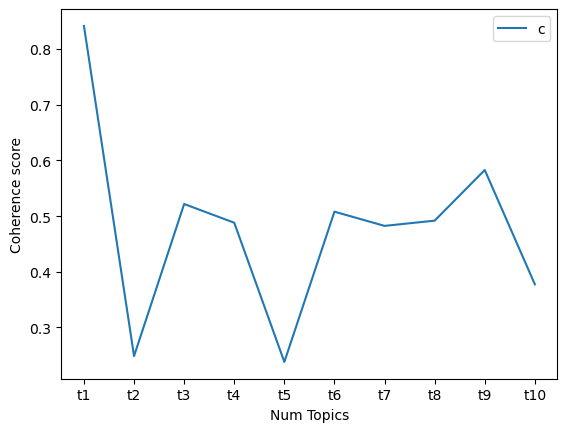

In [24]:
#Visualizing THE C_V scores of the lda model
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_ldas = coherence_model_lda.get_coherence_per_topic()
print('\nCoherence Score: ', coherence_ldas)

import matplotlib.pyplot as plt
import numpy as np
topicsname=[]
for i in range(1,11):
    topicsname.append("t{0}".format(i))
topicsname

plt.plot(topicsname,coherence_ldas)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [25]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join(r'C:\Users\Ayush\Github\clone\LDA-topic-modelling\lda_tuning_results.csv'+str(10))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if True:
    LDAvis_prepared = gensimvis.prepare(lda_model, bow_corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, r'C:\Users\Ayush\Github\clone\LDA-topic-modelling\lda_tuning_results.csv'+ str(10) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.084745  0.006228       1        1  20.471058
7      0.055427  0.014669       2        1  16.617845
3      0.000001  0.079765       3        1  11.123351
5      0.064091  0.064750       4        1  10.329497
8      0.213820 -0.081553       5        1  10.204094
1     -0.086920  0.067437       6        1   9.386386
6     -0.085483  0.074867       7        1   6.968222
9     -0.058124  0.035280       8        1   5.718158
4     -0.079828 -0.068326       9        1   5.634771
0     -0.107730 -0.193117      10        1   3.546620, topic_info=         Term         Freq        Total Category  logprob  loglift
157     india  1869.000000  1869.000000  Default  30.0000  30.0000
111    electr  2577.000000  2577.000000  Default  29.0000  29.0000
169      cell  1843.000000  1843.000000  Default  28.0000  28.0000
189    vehicl  1884.000000  1884.000000  Default  27.0000  27.0000
164       say  1511.000000  1511.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
361     avail    84.282234   404.134773  Topic10  -4.8713   1.7716
1358  session    71.425122   294.203709  Topic10  -5.0368   1.9236
28      power   103.872575  5467.913313  Topic10  -4.6623  -0.6243
46     carbon    62.261298  1510.702833  Topic10  -5.1741   0.1502
14      green    54.469418  3142.260421  Topic10  -5.3078  -0.7159

[673 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
863       1  0.086427        abl
863       2  0.123467        abl
863       3  0.080254        abl
863       4  0.012347        abl
863       5  0.018520        abl
...     ...       ...        ...
1060      5  0.034200  zeroemiss
1060      7  0.034200  zeroemiss
1060      8  0.013680  zeroemiss
1060      9  0.020520  zeroemiss
2315      8  0.938267       东福一号

[3129 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 8, 4, 6, 9, 2, 7, 10, 5, 1])